In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.concept_utils import conceptExample, gate_score
import numpy as np

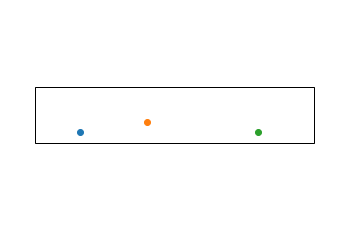

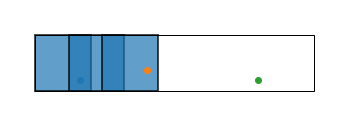

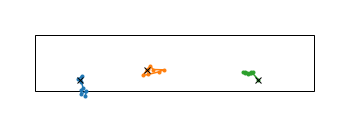

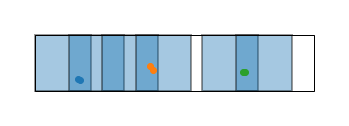

In [18]:
ce = conceptExample(var=0.005)

ce.plot_starting()
ce.plot_cams()
ce.plot_paths()
ce.plot_detections()


In [19]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.191239
1,1,0,0.776422,0.205055
2,2,1,2.061139,0.445951
3,3,1,2.118982,0.383438
4,5,2,3.720025,0.333955
5,6,2,3.767663,0.344350


In [20]:
def step_tracks(t, tracks, ce):
    det = ce.df[ce.df["time" ]==t]
    return ce.update_tracks(det, tracks)

In [21]:
def step_tracks_scores(t, tracks, ce, scores):
    det = ce.df[ce.df["time" ]==t]
#     gate_score(t, ce.df, ce.var, ce.thresh, np.multiply(*ce.cam_area), 3/5)
    return ce.update_score_tracks(det, tracks, scores)

In [22]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.191239
1,1,0,0.776422,0.205055
2,2,1,2.061139,0.445951
3,3,1,2.118982,0.383438
4,5,2,3.720025,0.333955
5,6,2,3.767663,0.344350


Make tracks and score them

In [23]:
tracks = ce.make_first_track()
scores = [0,0]

In [24]:
tracks1, scores1 = step_tracks_scores(1, tracks, ce, scores)
tracks2, scores2 = step_tracks_scores(2, tracks1, ce, scores1)
tracks3, scores3 = step_tracks_scores(3, tracks2, ce, scores2)
tracks4, scores4 = step_tracks_scores(4, tracks3, ce, scores3)
tracks5, scores5 = step_tracks_scores(5, tracks4, ce, scores4)
tracks6, scores6 = step_tracks_scores(6, tracks5, ce, scores5)

insnan last
insnan last
insnan last
insnan last
insnan last


In [25]:
np.log(0.4)#1-ce.density * np.multiply(*ce.cam_area)

-0.916290731874155

In [26]:
for i, t in enumerate(tracks1):
    print(t, scores1[i])

[0, nan] -0.01005033585350145
[0, 1] 3.459474120392786
[nan, nan] -0.01005033585350145
[nan, 1] -0.01005033585350145


In [27]:
for i, t in enumerate(tracks2):
    print(t, scores2[i])

[0, nan, nan] -0.0201006717070029
[0, nan, 2] 2.692912566183567
[0, 1, nan] 3.4494237845392846
[0, 1, 2] 6.873701194095537
[nan, nan, nan] -0.0201006717070029
[nan, nan, 2] -0.0201006717070029
[nan, 1, nan] -0.0201006717070029
[nan, 1, 2] 3.4041767378492485


**Make graph**

In [28]:
gtrack = np.array(tracks3)

In [29]:
import igraph

Graph building
1. Each track is a node
2. tracks which share a detection are incompatible so have an edge between

Make a graph with n vertices (where n is number of tracks)

In [30]:
g = igraph.Graph()
nverts = len(gtrack)
g.add_vertices(nverts)

Find the incompatible tracks

In [31]:
edges = []

for i, tr in enumerate(gtrack):
    diff = tr - gtrack
    for d in np.where(diff==0)[0]:
        if d != i:
            edges.append((i, d))

add edges to the graph

In [32]:
g.add_edges(edges)

In [33]:
hyps = g.maximal_independent_vertex_sets()

In [34]:
hyps

[(0, 8, 9, 10, 12),
 (0, 8, 9, 14),
 (0, 8, 15),
 (0, 8, 10, 13),
 (0, 8, 11, 12),
 (1, 8, 10, 12),
 (1, 8, 14),
 (2, 8, 9, 12),
 (2, 8, 13),
 (3, 8, 12),
 (4, 8, 9, 10),
 (4, 8, 11),
 (5, 8, 10),
 (6, 8, 9),
 (7, 8)]

Score the generated hypotheses

In [35]:
def score_hypotheses(hyps, scores):
    hscores = []
    for hyp in hyps:
        hscores.append(np.sum([scores[h] for h in hyp]))
    return hscores

In [36]:
hscores = score_hypotheses(hyps,scores3 )

In [37]:
for i, h in enumerate(hscores):
    print(hyps[i], h)

(0, 8, 9, 10, 12) -0.15075503780252175
(0, 8, 9, 14) 3.3036733793142337
(0, 8, 15) 6.801303859552091
(0, 8, 10, 13) 2.5890214738426574
(0, 8, 11, 12) 3.3468754424353353
(1, 8, 10, 12) 2.169650462471976
(1, 8, 14) 5.6240788795887315
(2, 8, 9, 12) 2.5924092076485525
(2, 8, 13) 5.332185719293731
(3, 8, 12) 6.090039687886409
(4, 8, 9, 10) 3.34892042600427
(4, 8, 11) 6.846550906242127
(5, 8, 10) 6.088696937649449
(6, 8, 9) 6.803348843121027
(7, 8) 10.300979323358883


In [47]:
nscores = []
for i, h in enumerate(hscores):
    nscores.append(h/len(hyps[i]))

In [52]:
for h in hyps:
    print(len(h))

5
4
3
4
4
4
3
4
3
3
4
3
3
3
2


In [49]:
hscores

[-0.15075503780252175,
 3.3036733793142337,
 6.801303859552091,
 2.5890214738426574,
 3.3468754424353353,
 2.169650462471976,
 5.6240788795887315,
 2.5924092076485525,
 5.332185719293731,
 6.090039687886409,
 3.34892042600427,
 6.846550906242127,
 6.088696937649449,
 6.803348843121027,
 10.300979323358883]

In [50]:
nscores

[-0.030151007560504352,
 0.8259183448285584,
 2.2671012865173634,
 0.6472553684606643,
 0.8367188606088338,
 0.542412615617994,
 1.8746929598629105,
 0.6481023019121381,
 1.7773952397645771,
 2.0300132292954696,
 0.8372301065010676,
 2.2821836354140426,
 2.02956564588315,
 2.267782947707009,
 5.150489661679441]

In [48]:
np.argsort(nscores)

array([ 0,  5,  3,  7,  1,  4, 10,  8,  6, 12,  9,  2, 13, 11, 14])

In [38]:
np.argsort(hscores)

array([ 0,  5,  3,  7,  1,  4, 10,  8,  6, 12,  9,  2, 13, 11, 14])

In [43]:
[gtrack[h] for h in hyps[11]]

[array([ 0.,  1., nan, nan]),
 array([nan, nan, nan, nan]),
 array([nan, nan,  2.,  3.])]

In [40]:
tracks2

[[0, nan, nan],
 [0, nan, 2],
 [0, 1, nan],
 [0, 1, 2],
 [nan, nan, nan],
 [nan, nan, 2],
 [nan, 1, nan],
 [nan, 1, 2]]

In [41]:
scores2

[-0.0201006717070029,
 2.692912566183567,
 3.4494237845392846,
 6.873701194095537,
 -0.0201006717070029,
 -0.0201006717070029,
 -0.0201006717070029,
 3.4041767378492485]

In [53]:
np.linalg.det(np.array([[3, 0], [0, 3]]))

9.000000000000002